# Introduction

Kaggle is a site where people create algorithms and compete against machine learning practitioners around the world.

The most popular of these competitions, is about predicting which passengers survived the sinking of the Titanic.

In this competition, we have a data set of different information about passengers onboard the Titanic, and we see if we can use that information to predict whether those people survived or not. Before we start looking at this specific competition, let's take a moment to understand how Kaggle competitions work.

Each Kaggle competition has two key data files; a training set and a testing set.

The training set contains data we can use to train our model. It has a number of feature columns which contain various descriptive data, as well as a column of the target values we are trying to predict: in this case, Survival.

The testing set contains all of the same feature columns, but is missing the target value column. Additionally, the testing set usually has fewer observations (rows) than the training set.

This is useful because we want as much data as we can to train our model on. Once we have trained our model on the training set, we will use that model to make predictions on the data from the testing set, and submit those predictions to Kaggle.

In this competition, the two files are named test.csv and train.csv.

Data Dictionary:
 - PassengerID - A column added by Kaggle to identify each row and make submissions easier
 - Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
 - Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
 - Sex - The passenger's sex
 - Age - The passenger's age in years
 - SibSp - The number of siblings or spouses the passenger had aboard the Titanic
 - Parch - The number of parents or children the passenger had aboard the Titanic
 - Ticket - The passenger's ticket number
 - Fare - The fare the passenger paid
 - Cabin - The passenger's cabin number
 - Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

_Competition Page: https://www.kaggle.com/c/titanic/data_
## Exploring the Dataset

In [1]:
import pandas as pd

#read in dataframes and explore shapes
test = pd.read_csv("test.csv")
test_shape = test.shape
train = pd.read_csv('train.csv')
train_shape = train.shape
print(train_shape, test_shape)

(891, 12) (418, 11)


We will be performing binary classification, because when we make predictions we are classifying each passenger as survived or not.

In this case, understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important. Having watched the movie Titanic, we remember that women and children were given preference to lifeboats (as they were in real life). We also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

Because the Survived column contains 0 if the passenger did not survive and 1 if they did, we can segment our data by sex and calculate the mean of this column.

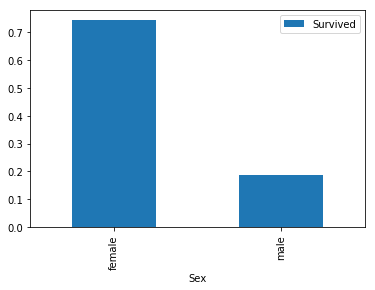

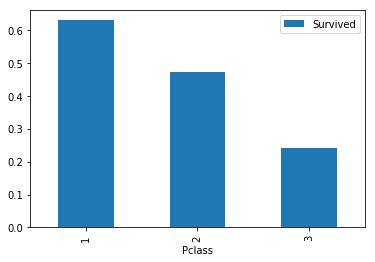

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#creating pivot table for Sex and Pclass
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()
class_pivot = train.pivot_table(index='Pclass', values = 'Survived')
class_pivot.plot.bar()
plt.show()

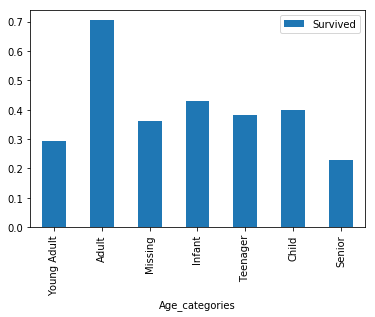

In [3]:
#function to convert Age from continuous to categorical values
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

#defining cutoff points for categories
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

#applying function on the data
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

#display pivot table
pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don't imply any numeric relationship where there isn't one. While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers 1, 2, and 3. For instance, class 2 isn't "worth" double what class 1 is, and class 3 isn't "worth" triple what class 1 is.

Therefore, we create dummy variables for each of the three predictors.

In [4]:
#function creates dummy variables and concatenates them to the dataframes
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

#applying the functions
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

## Logistic Regression

In [5]:
#choose columns that will be selected as features into the model
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

We have a test dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the Survived column we would have to submit it to Kaggle to find out our accuracy. This would quickly become a pain if we had to submit to find out the accuracy every time we optimized our model.

We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model will overfit.

Therefore, we split our training set into two parts: 80% as training data, 20% as testing data.

In [9]:
#import test_train_split which performs the split described above
from sklearn.model_selection import train_test_split
#import logistic regression module from sci-kit learn
from sklearn.linear_model import LogisticRegression
#import accuracy score
from sklearn.metrics import accuracy_score

all_X = train[columns]
all_y = train['Survived']
#random_state allows for our results to be reproducible
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2, random_state=0)

#instantiate logistic regression object
lr = LogisticRegression()
#fit data on train set
lr.fit(train_X, train_y)
#predict data on test set (from split)
predictions = lr.predict(test_X)
#calculate the accuracy
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data, and then average the accuracy scores. We will be using, is called k-fold cross validation.

In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

#instantiate new logistic regression object
lr = LogisticRegression()
#use cross_val_score to perform cross-validation on our data
scores = cross_val_score(lr, all_X, all_y, cv = 10)
#get mean of scores
accuracy = np.mean(scores)
print("scores: ", scores)
print("accuracy: ", accuracy)

scores:  [0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
accuracy:  0.8024670865963002


From the results of our k-fold validation, you can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6%. This demonstrates why cross validation is important.

As it happens, our average accuracy score was 80.2%, which is not far from the 81.0% we got from our simple train/test split.

We are now ready to use the model we have built to train our final model and then make predictions on our unseen holdout data (Kaggle test data).

In [11]:
#referring to kaggle test data as 'holdout' data to avoid confusion
holdout = test
#performing logistic regression on holdout data
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

## Submission to Kaggle

We need to create a submission file. Each Kaggle competition can have slightly different requirements for the submission file. Here's what is specified on the Titanic competition evaluation page:

 - You should submit a csv file with exactly 418 entries plus a header row. 
 - Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

 - PassengerId (sorted in any order)
 - Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [12]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)

Our accuracy on the holdout data is 74.2% compared with the 80.2% accuracy we got with cross-validation indicates that our model is overfitting slightly to our training data.

There are many things we can do to improve the accuracy of our model. Here are some next steps:

Improving the features:
 - Feature Engineering: Create new features from the existing data.
 - Feature Selection: Select the most relevant features to reduce noise and overfitting.
 
Improving the model:
 - Model Selection: Try a variety of models to improve performance.
 - Hyperparameter Optimization: Optimize the settings within each particular machine learning model.
 
## Feature Preparation, Selection and Engineering

Our model above, was based on three columns from the original data: Age, Sex, and Pclass. However, there are other columns from the dataset to consider. We can ignore PassengerId, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore Survived, as this is what we're predicting, as well as the three columns we've already used.

Here is a list of the remaining columns:

 - SibSp - The number of siblings or spouses the passenger had aboard the Titanic
 - Parch - The number of parents or children the passenger had aboard the Titanic
 - Ticket - The passenger's ticket number
 - Fare - The fair the passenger paid
 - Cabin - The passengers cabin number
 - Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

At first glance, both the Name and Ticket columns look to be unique to each passenger. We will come back to these columns later, but for now we'll focus on the other columns.

Let's get some more information on the values within each remaining column.

In [13]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,G6,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


 - SibSp, Parch and Fare look to be standard numeric columns with no missing values. 
 - Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. 
 - Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data. Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.

In [14]:
#import minmax_scale: sci-kit learn's scaling function
from sklearn.preprocessing import minmax_scale

# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

columns = ["SibSp","Parch","Fare"]

#fill in missing Embarked values with 'S'
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

#create dummy variables for 'Embarked'
train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

#scale all columns
for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

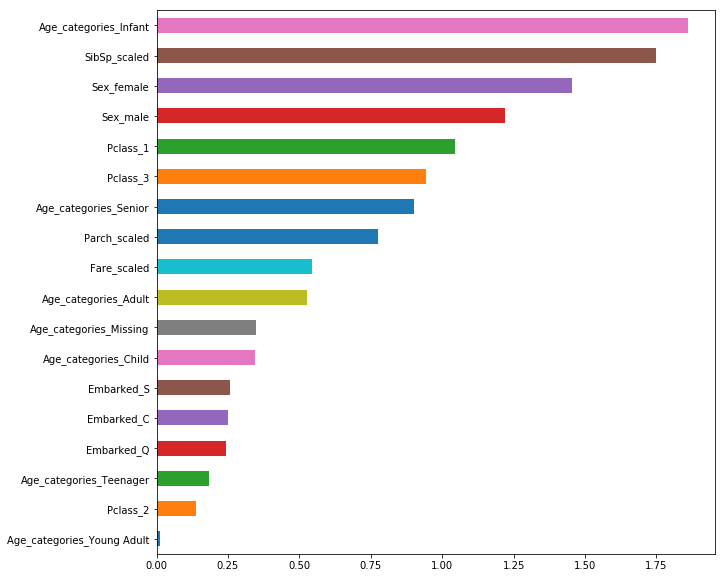

In [15]:
#setting up feature columns
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
#obtaining algorithm coefficients
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
#visualizing the coefficients
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh(figsize = (10,10))
plt.show()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [16]:
#top 8 scores
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv = 10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


The cross validation score of 81.5% is marginally higher than the cross validation score for the model we created in the previous mission, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [17]:
all_X = train[columns]
all_y = train['Survived']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_1.csv",index=False)

Our accuracy on the holdout data is 77.03% compared with the 81.5% accuracy we got with cross-validation indicates that our model is still overfitting slightly to our training data.

A lot of the gains in accuracy in machine learning come from Feature Engineering; creating new features from your existing data.

One common way to engineer a feature is using a technique called binning. This can be useful when there are patterns in the data that are non-linear and you're using a linear model, like logistic regression. We used binning earlier, when we dealt with the Age column. Let's do the same for the Fare column.

In [18]:
def process_fare(df, cut_points, label_names):
    df["Fare_categories"] = pd.cut(df["Fare"], cut_points, labels = label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

Another way to engineer features is by extracting data from text columns. Earlier, we decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from those two columns:

In [19]:
train[['Name', 'Cabin']].head(15)

,Name,Cabin
0,"Braund, Mr. Owen Harris",NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85
2,"Heikkinen, Miss. Laina",NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123
4,"Allen, Mr. William Henry",NaN
5,"Moran, Mr. James",NaN
6,"McCarthy, Mr. Timothy J",E46
7,"Palsson, Master. Gosta Leonard",NaN
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",NaN
9,"Nasser, Mrs. Nicholas (Adele Achem)",NaN


While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us. 

Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types: Mr, Mrs, Master, Miss, Officer, Royalty.

In [20]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

#use extract(), map() and the dictionary titles to categorize the 
#titles for the holdout dataframe and assign the results to a new column Title.
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

#use the str() accessor to extract the first letter from the Cabin column 
#use the fillna() method to fill any missing values in Cabin_type with "Unknown"
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

#create dummies for the new features
for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

We now have 34 possible feature columns we can use to train our model. However, we need to be aware of collinearity. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that your model will overfit. This will happen whenever we create dummy columns, and is called the dummy variable trap. The easy solution is to choose one column to drop any time you make dummy columns.

Let's plot correlations between each pair of variables in a heatmap, and see if there are any correlations we need to be aware of:

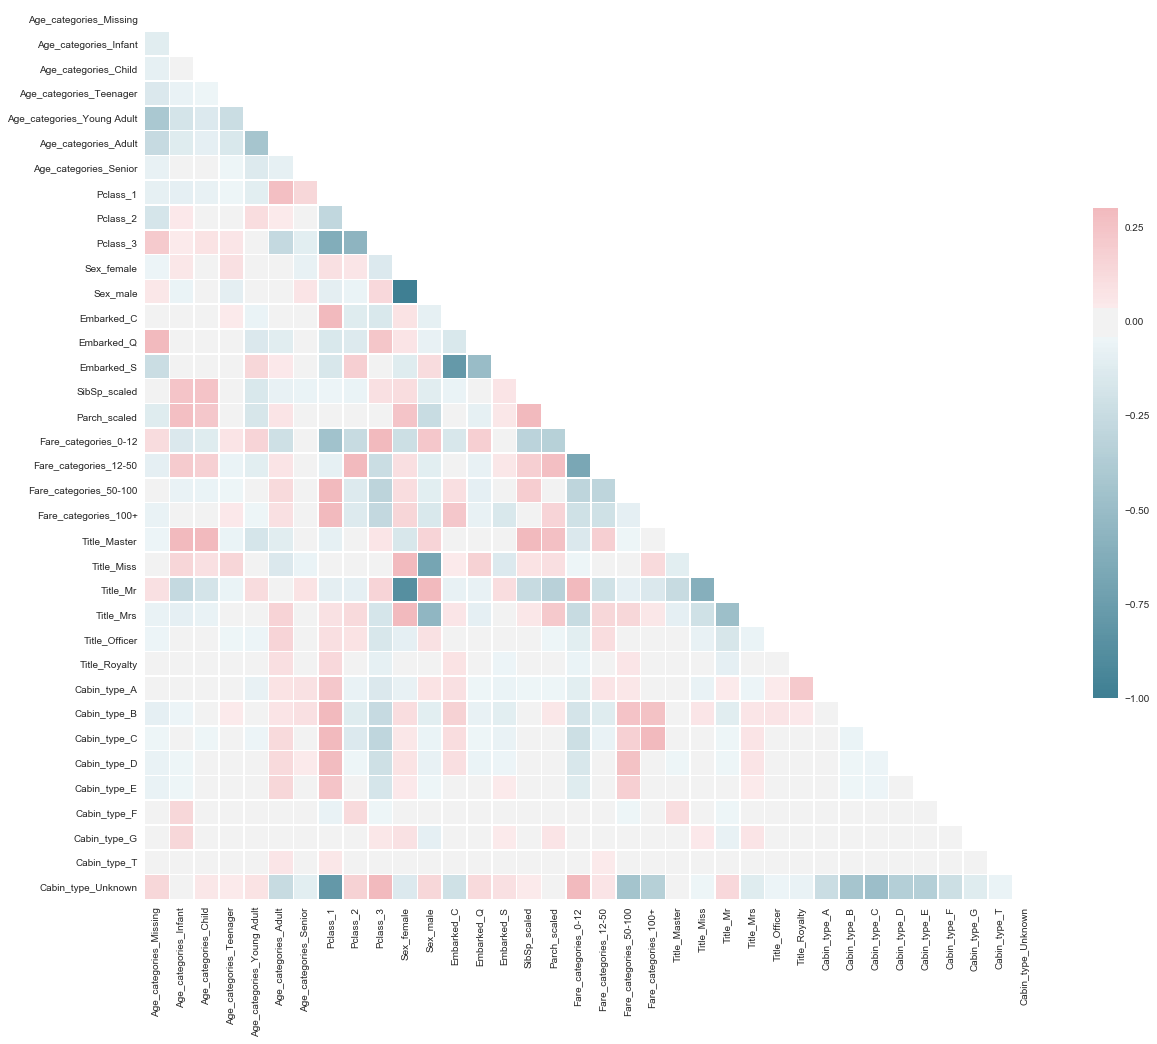

In [21]:
import seaborn as sns

#function to plot a pretty heatmap, code was found in seaborn example documentation
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(20, 18))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

 - Pclass_2
 - Age_categories_Teenager
 - Fare_categories_12-50
 - Title_Master
 - Cabin_type_A
 
Earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation.

The RFECV class starts by training a model using all of your features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Once the RFECV object has been fit, we can use the RFECV.support_ attribute to access a boolean mask of True and False values which we can use to generate a list of optimized columns.

In [22]:
#following code is explained in preceding text
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
optimized_columns = all_X.columns[selector.support_]
print(optimized_columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


In [23]:
#train model using optimal cols
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = scores.mean()
print(accuracy)

0.8226549199863807


This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model. Let's train these columns on the holdout set, save a submission file and see what score we get from Kaggle.

In [24]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

Our accuracy is now 78.5%, compared to 74.2% from our earlier submission; a significant increase.

Here are some ideas for features for this competition:

 - Use SibSp and Parch to explore total relatives onboard.
 - Create combinations of multiple columns, for instance Pclass + Sex.
 - See if you can extract useful data out of the Ticket column.
 - Try different combinations of features to see if you can identify features that overfit less than others.

Now, we'll look at selecting and optimizing different models to improve our score.

## Model Selection and Tuning

Earlier, we worked to optimize our predictions by creating and selecting the features used to train our model. The other half of the optimization puzzle is to optimize the model itself— or more specifically, the algorithm used to train our model.

So far, we've been using the logistic regression algorithm to train our models, however there are hundreds of different machine learning algorithms from which we can choose. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data.

Now, we're going work with two new algorithms: k-nearest neighbors and random forests.

We'll start with **k-nearest neighbors.** We're going to train our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity, but having more features will allow us to more thoroughly compare algorithms.

So we have something to compare to, we're going to train a logistic regression model like in the previous two missions. We'll use cross validation to get a baseline score.

In [34]:
#drop columns with non-numeric values
all_X = train.drop(['Survived','PassengerId', 'Pclass', 'Sex', 'Age', 'Age_categories', 'Cabin', 
                    'Name', 'Title', 'Cabin_type', 'Embarked', 'Fare', 'Fare_categories', 'Ticket',
                    'Cabin_type_T'],axis=1)

all_y = train['Survived']
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()
print(accuracy_lr)

0.821644251503802


The k-nearest neighbors algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

Besides pure model selection, we can vary the settings of each model — hyperparameter optimization.
We can use Sci-Kit Learn's GridSearch to find the optimal hyperparameters. We will only want to test odd values for k to avoid ties, where both 'survived' and 'died' outcomes would have the same number of neighbors.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.8361391694725028


This model had a cross-validation accuracy which is very slightly better than the linear regression model earlier. We now test this model on the holdout data and see how accurate it is.

In [36]:
holdout_dropped = holdout.drop(['PassengerId', 'Pclass', 'Sex', 'Age', 'Age_categories', 'Cabin', 
                    'Name', 'Title', 'Cabin_type', 'Embarked', 'Fare', 'Fare_categories', 'Ticket'],axis=1)

#use the GridSearchCV.best_estimator_ attribute to retrieve a 
#trained model with the best-performing hyperparameters
best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout_dropped)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_3.csv",index=False)

When we submit to Kaggle, wescores 76.6%, less than our best submission of 78.5%. While our model could be overfitting due to including all columns, it also seems like k-nearest neighbors may not be the best algorithm choice.

Let's try the **random forests algorithm.**

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()

In [38]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}
0.8439955106621774


In [40]:
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_dropped)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_4.csv",index=False)

By submitting tp Kaggle, it achieves a score of 77.5%, considerably better than our k-nearest neighbors score of 76.6% and very close (2 incorrect predictions) to our best score from the previous mission of 78.5%.

We will now work in a new file to create a clean Kaggle workflow including:
 - Further data exploration
 - Feature engineering
 - Feature selection
 - Model selection/tuning
 
The new workflow will also address extensions/next steps outlined in this notebook.